# Trying out keras and tensorflow

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import glob

## Loading dataset

### Training dataset

In [2]:
dirImage = 'chest_xray_pneumonia/selected_dataset/'

filenames_train = []
filenames_train += glob.glob(dirImage+"training/*.jpg")

train_images = []
for file in filenames_train:
    img = np.asarray(cv.imread(file, 0))
    train_images.append(img)

train_images = np.asarray(train_images)

train_labels = []
with open(dirImage+'training/training_labels.txt', 'r') as rd:
    for line in rd:
        train_labels.append(int(line))
train_labels = np.asarray(train_labels, dtype=np.uint8)
print('Training images: ', train_images.shape)
print('Training labels: ', len(train_labels))

Training images:  (3747, 688, 1024)
Training labels:  3747


Image: 


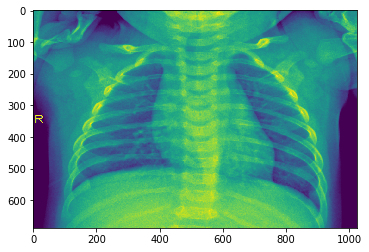

Label: 
0


In [3]:
i = np.random.randint(0, len(train_images))

print('Image: ')
plt.imshow(train_images[i])
plt.show()

print('Label: ')
print(train_labels[i])

In [4]:
dirImage = 'chest_xray_pneumonia/selected_dataset/'

filenames_val = []
filenames_val += glob.glob(dirImage+"validation/*.jpg")

val_images = []
for file in filenames_val:
    img = np.asarray(cv.imread(file, 0))
    val_images.append(img)

val_images = np.asarray(val_images)

val_labels = []
with open(dirImage+'validation/validation_labels.txt', 'r') as rd:
    for line in rd:
        val_labels.append(int(line))
val_labels = np.asarray(val_labels, dtype=np.uint8)
print('Validation images: ', val_images.shape)
print('Validation labels: ', len(val_labels))

Validation images:  (13, 688, 1024)
Validation labels:  13


Image: 


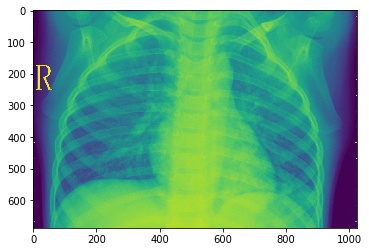

Label: 
0


In [5]:
i = np.random.randint(0, len(val_images))

print('Image: ')
plt.imshow(val_images[i])
plt.show()

print('Label: ')
print(val_labels[i])

In [6]:
dirImage = 'chest_xray_pneumonia/selected_dataset/'

filenames_test = []
filenames_test += glob.glob(dirImage+"testing/*.jpg")

test_images = []
for file in filenames_test:
    img = np.asarray(cv.imread(file, 0))
    test_images.append(img)

test_images = np.asarray(test_images)

test_labels = []
with open(dirImage+'testing/testing_labels.txt', 'r') as rd:
    for line in rd:
        test_labels.append(int(line))
test_labels = np.asarray(test_labels, dtype=np.uint8)
print('Testing images: ', test_images.shape)
print('Testing labels: ', len(test_labels))

Testing images:  (444, 688, 1024)
Testing labels:  444


Image: 


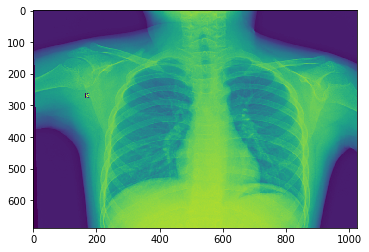

Label: 
1


In [7]:
i = np.random.randint(0, len(test_images))

print('Image: ')
plt.imshow(test_images[i])
plt.show()

print('Label: ')
print(test_labels[i])

## Pre-processing (Masking with Median Filter)

In [8]:
def median_filter(
    image=None, figure_size=9
):
    uimage = cv.medianBlur(image, figure_size)
    return uimage

In [9]:
mm_train_images = []
for i in train_images:
    uimage = median_filter(i.copy(), figure_size=9)
    mm_train_images.append(uimage)
mm_train_images = np.asarray(mm_train_images)

In [10]:
mm_val_images = []
for i in val_images:
    uimage = median_filter(i.copy(), figure_size=9)
    mm_val_images.append(uimage)
mm_val_images = np.asarray(mm_val_images)

In [11]:
mm_test_images = []
for i in test_images:
    uimage = median_filter(i.copy(), figure_size=9)
    mm_test_images.append(uimage)
mm_test_images = np.asarray(mm_test_images)

Image: 


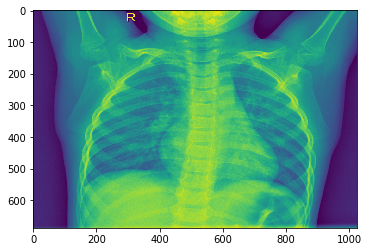

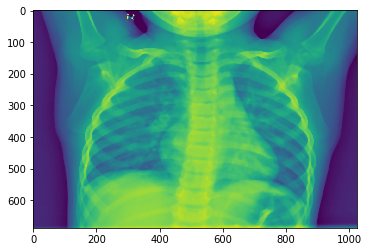

Label: 
0


In [12]:
# i = np.random.randint(0, len(train_images))
i=0
print('Image: ')
plt.imshow(train_images[i])
plt.show()
plt.imshow(mm_train_images[i])
plt.show()

print('Label: ')
print(train_labels[i])

Image: 


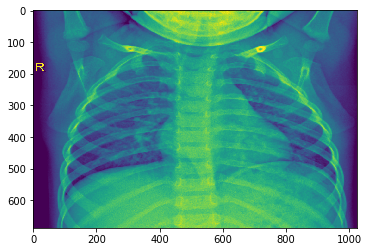

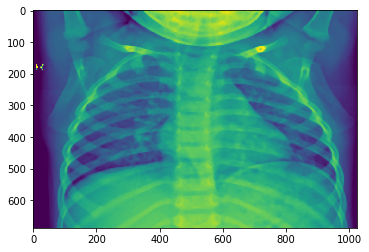

Label: 
1


In [13]:
i=-1
print('Image: ')
plt.imshow(train_images[i])
plt.show()
plt.imshow(mm_train_images[i])
plt.show()

print('Label: ')
print(train_labels[i])

## Scaling images

In [14]:
mm_train_images = mm_train_images / 255.0
mm_val_images = mm_val_images / 255.0
mm_test_images = mm_test_images / 255.0

### Preferred height and width setup

In [15]:
preferred_height = 688 # need to change with the height dimension of each selected images
preferred_width = 1024 # need to change with the width dimension of each selected images
n_d=1
n_c=2
n_epoch=10 # number of epochs, we might wanna start with smaller values 

### Performance Logger

In [16]:
class Logger(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.accuracy = []

    def on_epoch_end(self, batch, logs={}):
        self.accuracy.append(logs.get('acc'))
logger = Logger()

## Setting up model

In [17]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(688, 1024)),
    keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    keras.layers.Dense(n_c, activation='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Shuffler

In [19]:
def shuffler(x, y):
    r_list = np.random.permutation(np.arange(x.shape[0]))
    return x[r_list], y[r_list]

In [20]:
mm_train_images, train_labels = shuffler(mm_train_images, train_labels)

### Training

In [21]:
model.fit(mm_train_images, train_labels, epochs=1, 
          validation_data=(mm_val_images, val_labels), 
          callbacks=[logger])

Train on 3747 samples, validate on 13 samples
3747/3747 [==============================] - 376s 100ms/sample - loss: 5.7030 - acc: 0.6424 - val_loss: 9.9188 - val_acc: 0.3846


### Test

In [22]:
result = model.evaluate(mm_test_images, test_labels, verbose=0)
print('Accuracy: %s%s'%(result[1]*100, '%'))

Accuracy: 48.42342436313629%


### Visualization (Training)

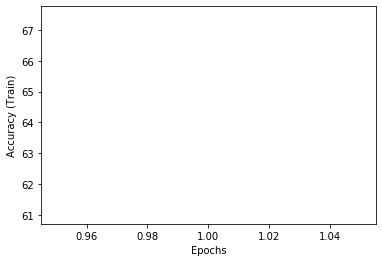

In [23]:
plt.plot(range(1,int(1+1)), [v*100 for v in logger.accuracy])
plt.xlabel('Epochs')
plt.ylabel('Accuracy (Train)')
plt.show()